In [1]:
## Dependencies

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from imutils import paths
from tqdm import tqdm
from keras.models import load_model
import keras.backend as K
import keras
from scipy.stats import norm
import tensorflow as tf
import matplotlib.animation as animation
from sklearn import metrics 
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import PCA
from numpy.linalg import svd

import pandas as pd
import random
from sklearn.manifold import TSNE
import seaborn as sns
import glob
from scipy import misc
import sklearn
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import filters
from keras.models import Sequential, Model
from keras.applications.vgg19 import VGG19
import tensorflow_probability as tfp
from functools import partial
from tensorflow_addons.layers import SpectralNormalization
from scipy.linalg import sqrtm
from functools import partial
from random import shuffle
from keras.layers.convolutional import Conv2D, InputSpec
from keras import initializers
from keras.layers import Input, Dense
from matplotlib.patches import Rectangle
import tensorflow_addons as tfa
import scipy.stats as st
from scipy.stats import wasserstein_distance

In [2]:
# verify versions


from platform import python_version
print(python_version())
print(tf.__version__)
print(keras.__version__)
tf.config.list_physical_devices('GPU')

3.9.10
2.6.2
2.6.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import GPUtil
from tabulate import tabulate
gpu = GPUtil.getGPUs()
print(gpu[0].name)

NVIDIA GeForce RTX 3090


In [4]:
## Spectral 1D/2D layers - used in training DISCOVER. Needed to load the saved networks

class DenseSN(Dense):
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True
        
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                 W_bar = K.reshape(W_bar, W_shape)  
        output = K.dot(inputs, W_bar)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

class ConvSN2D(Conv2D):

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv2d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs    

In [5]:
# Data loaded values

img_rows, img_cols = 64, 64
img_size = 64 
nmax = 5000
data_path = '/home/odedrot' # Parent PATH to DISCOVER folder

In [6]:
def sample_images(imgs, r,c):
    fig, axs = plt.subplots(r, c, figsize=(20,2*r))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    
def sample_images_labels(imgs, labels, r, c):
    fig, axs = plt.subplots(r, c, figsize=(20,2*r))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            axs[i,j].set_title(str(labels[cnt]), fontsize=20) # str(cnt) + ' - ' + 
            cnt += 1
    plt.show()

In [7]:
## load data

margin = 15 # cropping edges of faces images (for CelebA)

def load_images(directory):
    imagePaths = list(paths.list_images(directory))
    data = []
    images_name = []
    i = 1
    for imagePath in imagePaths:
        # images_name.append(imagePath.split("/")[5])
        image = cv2.imread(imagePath) # load the image
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # swap color channels
        image = image[margin:img_size-margin , margin:img_size-margin] 
        image = cv2.resize(image, (img_size,img_size) , interpolation = cv2.INTER_AREA)
        data.append(image)
        i = i+1
        if i>nmax:
            break
    req_images = np.array(data)
    req_images =  np.array(req_images).astype("float32")
    req_images = np.expand_dims(req_images, axis=-1)
    return req_images# , images_name

################################################################################################
# test
images0 = load_images(data_path + '/DISCOVER/GENDER/IMAGES/TEST_0') # ('/home/odedrot/images/Unet_images_64pix_clf_aa_test')
images1 = load_images(data_path + '/DISCOVER/GENDER/IMAGES/TEST_1') # ('/home/odedrot/images/Unet_images_64pix_clf_bc_test')
images = np.concatenate((images0, images1))
images = images/ 255
print(images.shape)

true_labels = np.array([np.zeros((images0.shape[0])) , np.ones((images1.shape[0]))]).flatten().astype('uint8')
##################################################################################################

(6, 64, 64, 1)


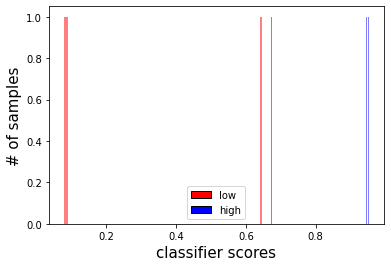

In [8]:
# check classifier predictions are similar to CLF training

saved_name = 'classifier.h5' # new
clf_model_path = data_path + '/DISCOVER/GENDER/GENDER_SAVED_MODELS/' + saved_name
clf_model = load_model(clf_model_path , compile=True)

images3D = images.repeat(3, -1)   
images3D_clfscore = clf_model.predict(images3D)

_ = plt.hist(images3D_clfscore[true_labels==0] , 100, alpha = 0.5, color= 'r')
_ = plt.hist(images3D_clfscore[true_labels==1] , 100, alpha = 0.5, color= 'b')
# plt.title('Quality scores based on real images', fontsize=20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.xlabel("classifier scores", fontsize=15)
plt.ylabel("# of samples", fontsize=15)
plt.show()

In [9]:
# https://github.com/OwalnutO/SSIM-Loss-Tensroflow/blob/master/SSIM_loss_class.py

def tf_ssim(img1, img2, k1=0.03, k2=0.003, WS=7, data_range=1):
    
    size = 7
    sigma=1.5
    x_data, y_data = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    x_data = np.expand_dims(x_data, axis=-1)
    x_data = np.expand_dims(x_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)
    x = tf.constant(x_data, dtype=tf.float32)
    y = tf.constant(y_data, dtype=tf.float32)
    g = tf.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    window = g / tf.reduce_sum(g)
    
    (_, _, _, channel) = img1.shape# .as_list()
    window = tf.tile(window, [1, 1, channel, 1])
    mu1 = tf.nn.depthwise_conv2d(img1, window, strides = [1, 1, 1, 1], padding = 'SAME')
    mu2 = tf.nn.depthwise_conv2d(img2, window, strides = [1, 1, 1, 1], padding = 'SAME')
    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    img1_2 = img1*img1 #tf.pad(img1*img1, [[0,0], [0, WS//2], [0, WS//2], [0,0]], "CONSTANT")
    sigma1_sq = tf.subtract(tf.nn.depthwise_conv2d(img1_2, window, strides = [1 ,1, 1, 1], padding = 'SAME') , mu1_sq)
    img2_2 = img2*img2 #tf.pad(img2*img2, [[0,0], [0, WS//2], [0, WS//2], [0,0]], "CONSTANT")
    sigma2_sq = tf.subtract(tf.nn.depthwise_conv2d(img2_2, window, strides = [1, 1, 1, 1], padding = 'SAME') ,mu2_sq)
    img12_2 = img1*img2 #tf.pad(img1*img2, [[0,0], [0, WS//2], [0, WS//2], [0,0]], "CONSTANT")
    sigma1_2 = tf.subtract(tf.nn.depthwise_conv2d(img12_2, window, strides = [1, 1, 1, 1], padding = 'SAME') , mu1_mu2)
    c1 = (k1*data_range)**2
    c2 = (k2*data_range)**2
    ssim_map = ((2*mu1_mu2 + c1)*(2*sigma1_2 + c2)) / ((mu1_sq + mu2_sq + c1)*(sigma1_sq + sigma2_sq + c2))
    
    return ssim_map

# https://nmarkou.blogspot.com/2020/10/gaussian-filter-in-keras-code-snippet.html
# https://stackoverflow.com/questions/55643675/how-do-i-implement-gaussian-blurring-layer-in-keras

def _gaussian_kernel(kernlen=[21, 21], nsig=[3, 3]):
        assert len(nsig) == 2
        assert len(kernlen) == 2
        kern1d = []
        for i in range(2):
            interval = (2 * nsig[i] + 1.) / (kernlen[i])
            x = np.linspace(-nsig[i] - interval / 2., nsig[i] + interval / 2.,
                            kernlen[i] + 1)
            kern1d.append(np.diff(st.norm.cdf(x)))

        kernel_raw = np.sqrt(np.outer(kern1d[0], kern1d[1]))
        # divide by sum so they all add up to 1
        kernel = kernel_raw / kernel_raw.sum()
        return kernel

# Initialise to set kernel to required value
def kernel_init(shape, dtype):
    kernel = np.zeros(shape)
    kernel[:, :, 0, 0] = _gaussian_kernel([shape[0], shape[1]])
    return kernel
    
def gaussian_filter_block(input_layer,
                          kernel_size=3,
                          strides=(1, 1),
                          dilation_rate=(1, 1),
                          padding="same",
                          activation=None,
                          trainable=False,
                          use_bias=False):

    return keras.layers.DepthwiseConv2D(
        kernel_size=kernel_size,
        strides=strides,
        padding=padding,
        depth_multiplier=1,
        dilation_rate=dilation_rate,
        activation=activation,
        use_bias=use_bias,
        trainable=trainable,
        depthwise_initializer=kernel_init,
        kernel_initializer=kernel_init)(input_layer)

# @tf.keras.utils.register_keras_serializable(package='Custom', name='Wvar_reg')
def Wvar_reg(weight_matrix):
    return tf.math.reduce_mean(tf.math.variance(weight_matrix))

In [12]:
##  load models

latent_dim = 350 # define latent dimentions


model_path = data_path + '/DISCOVER/GENDER/GENDER_SAVED_MODELS/'
encoder = load_model(model_path + 'encoder' + '.h5' , compile=False, custom_objects={'ConvSN2D': ConvSN2D , 'DenseSN': DenseSN, 'Wvar_reg': Wvar_reg})
decoder = load_model(model_path + 'generator' + '.h5' , compile=False, custom_objects={'ConvSN2D': ConvSN2D , 'DenseSN': DenseSN, 'Wvar_reg': Wvar_reg})
recognizer = load_model(model_path + 'disentangleNET' + '.h5' , compile=False, custom_objects={'ConvSN2D': ConvSN2D , 'DenseSN': DenseSN, 'Wvar_reg': Wvar_reg})
discriminator1D = load_model(model_path + 'discriminator1D' + '.h5' , compile=False, custom_objects={'ConvSN2D': ConvSN2D , 'DenseSN': DenseSN, 'Wvar_reg': Wvar_reg})



In [13]:
# encode/decode images

try:
    z_dist, Escore = encoder.predict(images)
except:
    z_dist = encoder.predict(images) 
    

images_recon = decoder.predict(z_dist)
print(z_dist.shape)
latent_dim = z_dist.shape[1]


(6, 350)


real samples


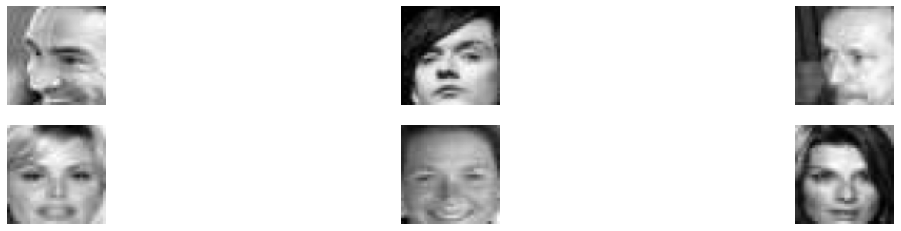


reconstructed samples


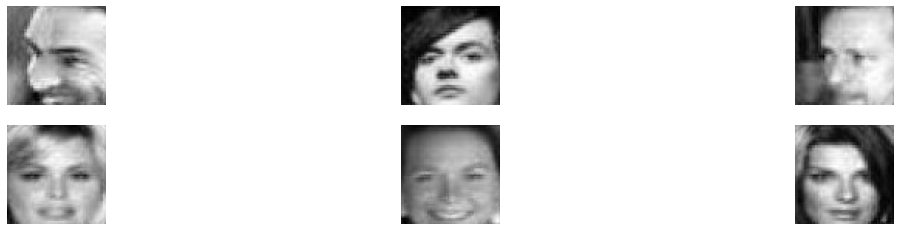

In [17]:
#  reconstruction
ids = range(6)
print('real samples')
sample_images(images[ids], 2,3) 
print('')
print('reconstructed samples')
sample_images(images_recon[ids], 2,3)


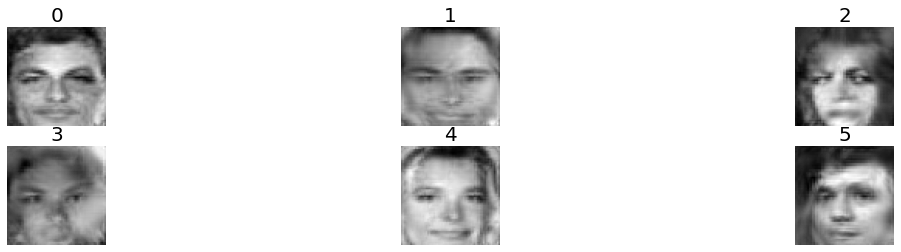

In [19]:
#  sample from normal distribution
n_samples = 6
z_samples = np.zeros((n_samples, z_dist.shape[1]))
for i in range(n_samples):
    for j in range(z_dist.shape[1]):
        ind = np.random.randint(0, z_dist.shape[0], 1)[0] # sample ids from images
        z_samples[i][j] = z_dist[ind][j]
imgs_samples = decoder.predict(np.expand_dims(z_samples, axis=-1))
sample_images_labels(imgs_samples, np.arange(0,z_samples.shape[0],1), 2,3)

VGG loss 0.3786342
CLF loss 0.36095786


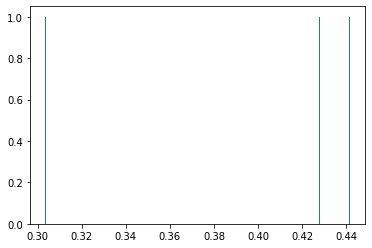

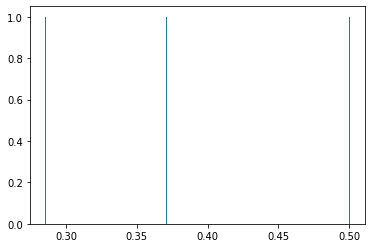

In [20]:
# calculating CLF and VGG perceptual loss

clf_outputs = [
               clf_model.get_layer('block2_conv1').output,
               clf_model.get_layer('block2_conv2').output,
               clf_model.get_layer('block3_conv2').output,
               clf_model.get_layer('block3_conv3').output,
               clf_model.get_layer('block5_conv2').output,
               clf_model.get_layer('block5_conv3').output,
               clf_model.get_layer('flatten').output,
               clf_model.get_layer('dense_1').output,]

CNN_clf_Model_outputs = Model(inputs=clf_model.input, outputs = clf_outputs)
CNN_clf_Model_outputs.trainable = False # we dont train the CNN

VGG_model = VGG19(weights="imagenet", include_top=False, input_shape=(img_rows, img_cols,3)) # ResNet50 , VGG16, VGG19
VGG_outputs = [
               # VGG_model.get_layer('block1_conv1').output,   
               # VGG_model.get_layer('block1_conv2').output,
               # VGG_model.get_layer('block2_conv1').output,
               # VGG_model.get_layer('block2_conv2').output,   
               VGG_model.get_layer('block3_conv1').output,   
               VGG_model.get_layer('block3_conv2').output,
               VGG_model.get_layer('block3_conv3').output,
               VGG_model.get_layer('block4_conv1').output,
               VGG_model.get_layer('block4_conv2').output,
               VGG_model.get_layer('block4_conv3').output,
               VGG_model.get_layer('block4_conv4').output,
               VGG_model.get_layer('block5_conv1').output,
               VGG_model.get_layer('block5_conv2').output,
               VGG_model.get_layer('block5_conv3').output,
               VGG_model.get_layer('block5_conv4').output,]           
            
VGG_Model_outputs = Model(inputs=VGG_model.input, outputs = VGG_outputs)
VGG_Model_outputs.trainable = False # we dont train the CNN

def model_perc_loss_wrapper(model):
    def model_perc_loss(y_true, y_pred):
        # weights = [1,1,1]
        img_outputs = model( y_true ) 
        recon_img_outputs = model( y_pred ) 
        layers_losses = []
        for i in range(len(recon_img_outputs)):
            layers_losses.append(K.mean(K.abs(img_outputs[i] - recon_img_outputs[i])))
        avg_loss = K.mean(tf.convert_to_tensor(layers_losses))
        return avg_loss
    return model_perc_loss

VGG_loss = []
CLF_loss = []
# for i in range(0,2625,525):
#     VGG_loss.append( model_perc_loss_wrapper(VGG_Model_outputs)(images[i:i+525].repeat(3, -1), images_recon[i:i+525].repeat(3, -1)).numpy() )
#     CLF_loss.append( model_perc_loss_wrapper(CNN_clf_Model_outputs)(images[i:i+525].repeat(3, -1), images_recon[i:i+525].repeat(3, -1)).numpy() )
# print('VGG loss' , np.array(VGG_loss).mean())
# print('CLF loss' , np.array(CLF_loss).mean())

for i in range(len(images)):
    VGG_loss.append( model_perc_loss_wrapper(VGG_Model_outputs)(images[i:i+1].repeat(3, -1), images_recon[i:i+1].repeat(3, -1)).numpy() )
    CLF_loss.append( model_perc_loss_wrapper(CNN_clf_Model_outputs)(images[i:i+1].repeat(3, -1), images_recon[i:i+1].repeat(3, -1)).numpy() )

print('VGG loss' , np.array(VGG_loss).mean())
print('CLF loss' , np.array(CLF_loss).mean())

_ = plt.hist(np.array(VGG_loss), 1000)
plt.show()
_ = plt.hist(np.array(CLF_loss), 1000)
plt.show()

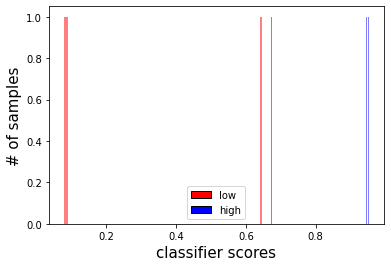

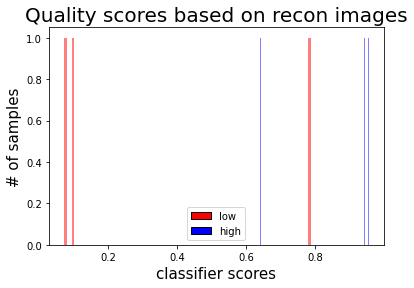

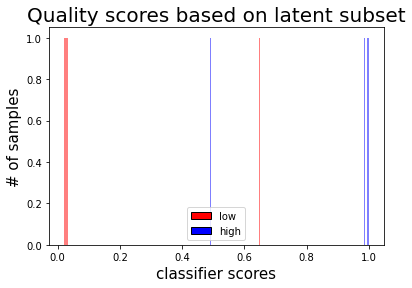

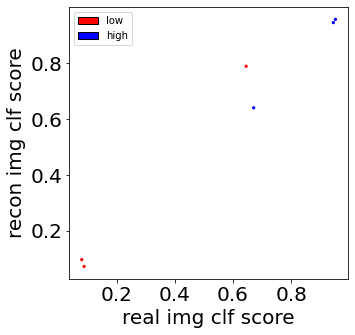

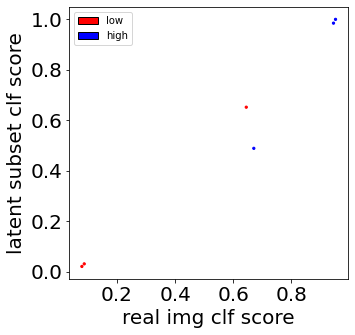

auc true vs real  1.0
auc true vs recon 0.888888888888889
auc true vs z_score 0.888888888888889
mae(clf(x), clf(xrecon))  0.035280973
mae(clf(x), clf(z_score))  0.06475093


In [21]:
# real vs recon clf scores

images3D = images.repeat(3, -1)   
images3D_clfscore = clf_model.predict(images3D)

images_recon3D = images_recon.repeat(3, -1)   
images_recon3D_clfscore = clf_model.predict(images_recon3D)
###############################################
_ = plt.hist(images3D_clfscore[true_labels==0] , 100, alpha = 0.5, color= 'r')
_ = plt.hist(images3D_clfscore[true_labels==1] , 100, alpha = 0.5, color= 'b')
# plt.title('Quality scores based on real images', fontsize=20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.xlabel("classifier scores", fontsize=15)
plt.ylabel("# of samples", fontsize=15)
plt.show()

_ = plt.hist(images_recon3D_clfscore[true_labels==0] , 100, alpha = 0.5, color= 'r')
_ = plt.hist(images_recon3D_clfscore[true_labels==1] , 100, alpha = 0.5, color= 'b')
plt.title('Quality scores based on recon images', fontsize=20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.xlabel("classifier scores", fontsize=15)
plt.ylabel("# of samples", fontsize=15)
plt.show()

_ = plt.hist(Escore[true_labels==0] , 100, alpha = 0.5, color= 'r')
_ = plt.hist(Escore[true_labels==1] , 100, alpha = 0.5, color= 'b')
plt.title('Quality scores based on latent subset', fontsize=20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.xlabel("classifier scores", fontsize=15)
plt.ylabel("# of samples", fontsize=15)
plt.show()

###############################################

cols=[]
for l in true_labels:
    if l==0:
        cols.append('red')
    elif l==1:
        cols.append('blue')
plt.figure(figsize=(5,5))
plt.scatter(images3D_clfscore, images_recon3D_clfscore, c=cols, s=5, cmap='gray')
plt.xlabel("real img clf score", fontsize=20)
plt.ylabel("recon img clf score", fontsize=20)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(images3D_clfscore, Escore, c=cols, s=5, cmap='gray')
plt.xlabel("real img clf score", fontsize=20)
plt.ylabel("latent subset clf score", fontsize=20)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["red", "blue"] ]
labels= ["low", "high"]
plt.legend(handles, labels)
plt.show()


# calculate auc for real and recon imgs vs true labels (drop not aa or bb bc cb cc)

true_labels_0_1 = []
images3D_clfscore_0_1 = []
images_recon3D_clfscore_0_1 = []
Escore_0_1 = []
for i in range(len(true_labels)):
    if true_labels[i] == 0 or true_labels[i] == 1:
        true_labels_0_1.append(true_labels[i]) 
        images3D_clfscore_0_1.append(images3D_clfscore[i])
        images_recon3D_clfscore_0_1.append(images_recon3D_clfscore[i])
        Escore_0_1.append(Escore[i])

fpr, tpr, thresholds = metrics.roc_curve(true_labels_0_1, images3D_clfscore_0_1)
print('auc true vs real ' , metrics.auc(fpr, tpr))
recon_fpr, recon_tpr, recon_thresholds = metrics.roc_curve(true_labels_0_1, images_recon3D_clfscore_0_1)
print('auc true vs recon' ,metrics.auc(recon_fpr, recon_tpr))
recon_fpr, recon_tpr, recon_thresholds = metrics.roc_curve(true_labels_0_1, Escore_0_1)
print('auc true vs z_score' ,metrics.auc(recon_fpr, recon_tpr))
###############################################
# mae 
print('mae(clf(x), clf(xrecon)) ' , np.mean(np.abs(images3D_clfscore - images_recon3D_clfscore )) )
print('mae(clf(x), clf(z_score)) ' , np.mean(np.abs(images3D_clfscore - Escore )) )

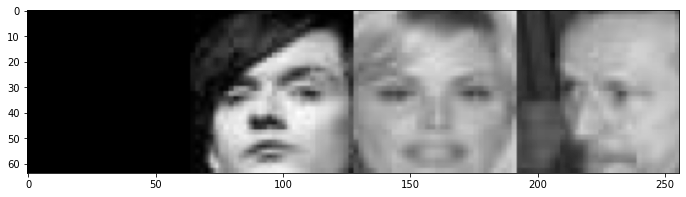

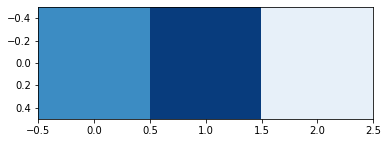

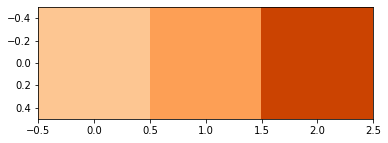

[[-1.2829736], [-0.40416884], [1.6940408]]


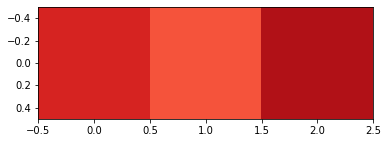

In [22]:
# images from different bin values 
tmp_imgs = []
tmp_scores = []
tmp_values = []
tmp_names = []
one_img = np.zeros((64,64))
ranges = np.linspace(-3,3,7)
dim=2 ##########################################
for i in range(len(ranges)):
    try:
        idx = np.where( (z_dist[:,dim] > ranges[i]) * (z_dist[:,dim] < ranges[i+1]) )[0] 
        rand_idx_in_range = np.random.randint(0, idx.shape, 1)[0]
        tmp_values.append( [z_dist[idx[rand_idx_in_range],dim]])
        tmp_imgs.append(images[idx[rand_idx_in_range]])
        # tmp_names.append(names[idx[rand_idx_in_range]])
        one_img = np.concatenate((one_img, images[idx[rand_idx_in_range]][:,:,0]), axis=-1)
        tmp_scores.append(np.array(images3D_clfscore_0_1)[idx[rand_idx_in_range]])
    except:
        f=0
tmp_imgs = np.array(tmp_imgs)
# sample_images_labels(tmp_imgs, tmp_scores)

plt.figure(figsize=(20,3))
plt.imshow(one_img, cmap='gray')
plt.show()
plt.imshow(np.array(tmp_scores).T, cmap='Blues' , vmin=0 , vmax=1)
plt.show()
plt.imshow(np.array(tmp_values).T, cmap='Oranges' , vmin=-3 , vmax=3)
plt.show()
print(tmp_values)


z_imgs, z_scores = encoder(tmp_imgs)
plt.imshow(np.expand_dims(z_imgs[:,0].numpy(), -1).T, cmap='Reds' , vmin=-3 , vmax=3)
plt.show()

# print(tmp_names)

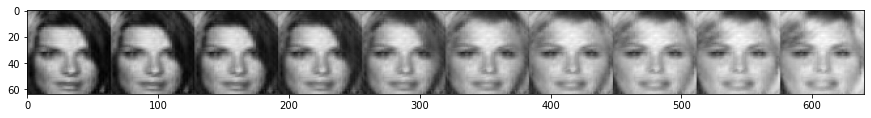

In [23]:
# interpolation between high and low images 


def slerp(val, low, high):
    omega = np.arccos(np.clip(np.dot(low/norm(low), high/norm(high)), -1, 1))
    so = sin(omega)
    if so == 0:
        return (1.0-val) * low + val * high
    return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high


# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2 # uniform #   
        # v = slerp(ratio, p1, p2)# spherical 
        vectors.append(v)
    return np.asarray(vectors)

low_idx = np.where(np.array(images3D_clfscore_0_1) >0.8)[0] # <0.2
low_rand_idx = np.random.randint(0, low_idx.shape, 1)[0]
low_image = images[low_idx[low_rand_idx]]
low_image_score = np.array(images3D_clfscore_0_1)[low_idx[low_rand_idx]]
low_z_dist = z_dist[low_idx[low_rand_idx]]

high_idx = np.where(np.array(images3D_clfscore_0_1) >0.8)[0]
high_rand_idx = np.random.randint(0, high_idx.shape, 1)[0]
high_image = images[high_idx[high_rand_idx]]
high_image_score = np.array(images3D_clfscore_0_1)[high_idx[high_rand_idx]]
high_z_dist = z_dist[high_idx[high_rand_idx]]


    
interpolated = interpolate_points(high_z_dist, low_z_dist)
decoded_interpolated = decoder.predict(interpolated)
plt.figure(figsize=(15,10))
plt.imshow(np.hstack((decoded_interpolated)), cmap='gray')


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

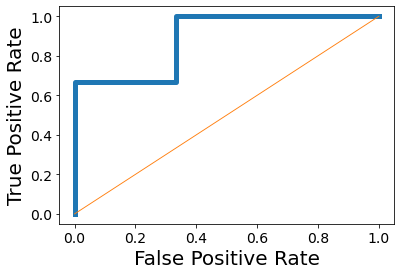

In [24]:
# ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(true_labels, images_recon3D_clfscore)  
plt.plot(fpr, tpr, linewidth=5)
plt.plot([0, 1], [0, 1], linewidth=0.9)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

baseline normal distribution vectors
latent_cov_loss  82440.3  off_diag_mean  0.2871242  diag_mean  0.8403775691986084
z images
latent_cov_loss  81615.93  off_diag_mean  0.28568503  diag_mean  0.8297666907310486


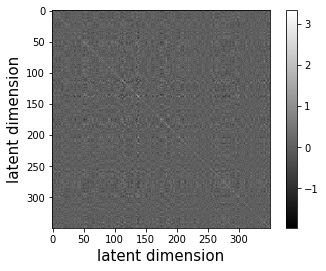

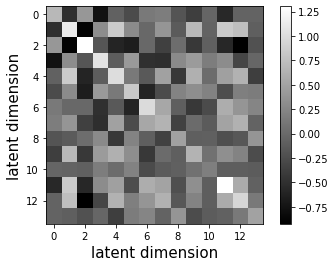

off diag max values (5)  [0.84558725 0.84558725 0.83700585 0.83700585 0.74015075]


In [25]:
# covariance

def get_off_diag_values(x):
    x_flat = tf.reshape(x,[-1])[:-1]
    x_reshape = tf.reshape(x_flat,[x.shape[0]-1, x.shape[0]+1])[:, 1:]
    off_diag_values = tf.reshape(x_reshape,[-1])
    return off_diag_values
def cov_loss_terms(z):
    cov = tfp.stats.covariance(z)
    diag_cov = tf.linalg.diag_part(cov)
    diag_cov_mean = tf.reduce_mean(diag_cov)
    diag_cov_loss = 1 - diag_cov_mean
    off_diag_values =  get_off_diag_values(cov)
    # A = tf.abs(off_diag_values)
    # A = tf.convert_to_tensor(A[A>0.05])
    # off_diag_loss = tf.reduce_mean(A)
    off_diag_loss = tf.reduce_mean(tf.abs(off_diag_values))
    return cov, diag_cov_loss , off_diag_loss
def calc_cov_loss(y_true, ypred):
    cov, diag_cov_loss , off_diag_loss = cov_loss_terms(y_true)
    cov_loss = 0.000001*diag_cov_loss + 1000000*off_diag_loss**2
    return cov_loss

############### random vecs
print('baseline normal distribution vectors')
var = 1.0
z_normal = tf.random.normal([z_dist.shape[0], z_dist.shape[1]], 0, var, tf.float32)
cov_loss = calc_cov_loss(z_normal, z_normal)
cov, diag_cov_loss , off_diag_loss = cov_loss_terms(z_normal)
print('latent_cov_loss ', cov_loss.numpy() , ' off_diag_mean ' , off_diag_loss.numpy() , ' diag_mean ', 1 - diag_cov_loss.numpy())


print('z images')
cov_loss = calc_cov_loss(z_dist, z_dist)
cov, diag_cov_loss , off_diag_loss = cov_loss_terms(z_dist)
print('latent_cov_loss ', cov_loss.numpy() , ' off_diag_mean ' , off_diag_loss.numpy() , ' diag_mean ', 1 - diag_cov_loss.numpy())

plt.imshow(cov, cmap='gray')
plt.xlabel("latent dimension", fontsize=15)
plt.ylabel("latent dimension", fontsize=15)
plt.colorbar()
plt.show()

plt.imshow(cov[0:14, 0:14], cmap='gray')
plt.xlabel("latent dimension", fontsize=15)
plt.ylabel("latent dimension", fontsize=15)
plt.colorbar()
plt.show()
print( 'off diag max values (5) ' , np.sort(get_off_diag_values(cov[0:14, 0:14]))[::-1][0:5] )


# z_cov = z_dist
# cov = tfp.stats.covariance(z_cov)
# diag_mean = tf.reduce_sum(tf.linalg.diag_part(cov)) / cov.shape[0]
# off_diag_mean = ( tf.reduce_sum(cov) - tf.reduce_sum(tf.linalg.diag_part(cov)) ) / (cov.shape[0]*2 - cov.shape[0])
# cov_loss = tf.reduce_mean((diag_mean - 1)**2) + tf.reduce_mean(off_diag_mean**2)
# print('latent_cov_loss ', cov_loss.numpy() , ' off_diag_mean ' , off_diag_mean.numpy() , ' diag_mean ', diag_mean.numpy())




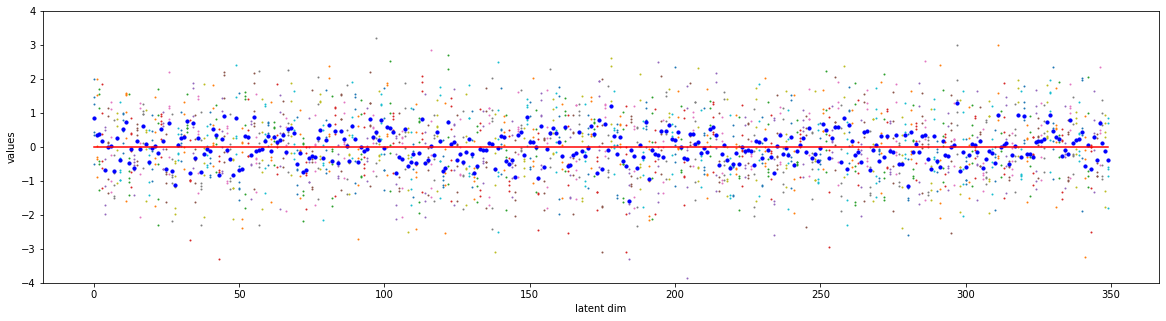

In [26]:
# distribution of dim
plt.figure(figsize=(20, 5))
for i in range (latent_dim):
    plt.scatter(i*np.ones((1,z_dist.shape[0])), z_dist[:, i], s=1)
    plt.scatter(i, np.mean(z_dist[:, i]), c='b', s=10)
    plt.xlabel('latent dim')
    plt.ylabel('values')
    plt.ylim([-4,4])
plt.plot(np.zeros((latent_dim,1)), 'r-', markersize=20)  
plt.show()

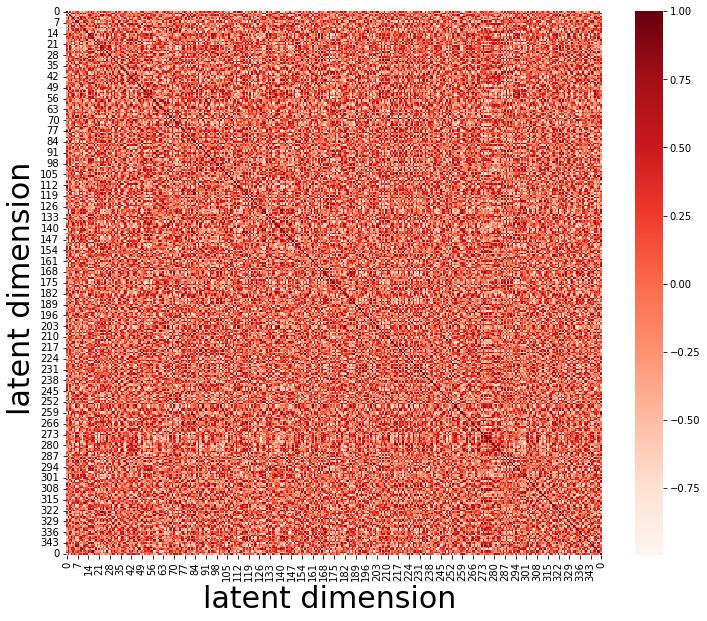

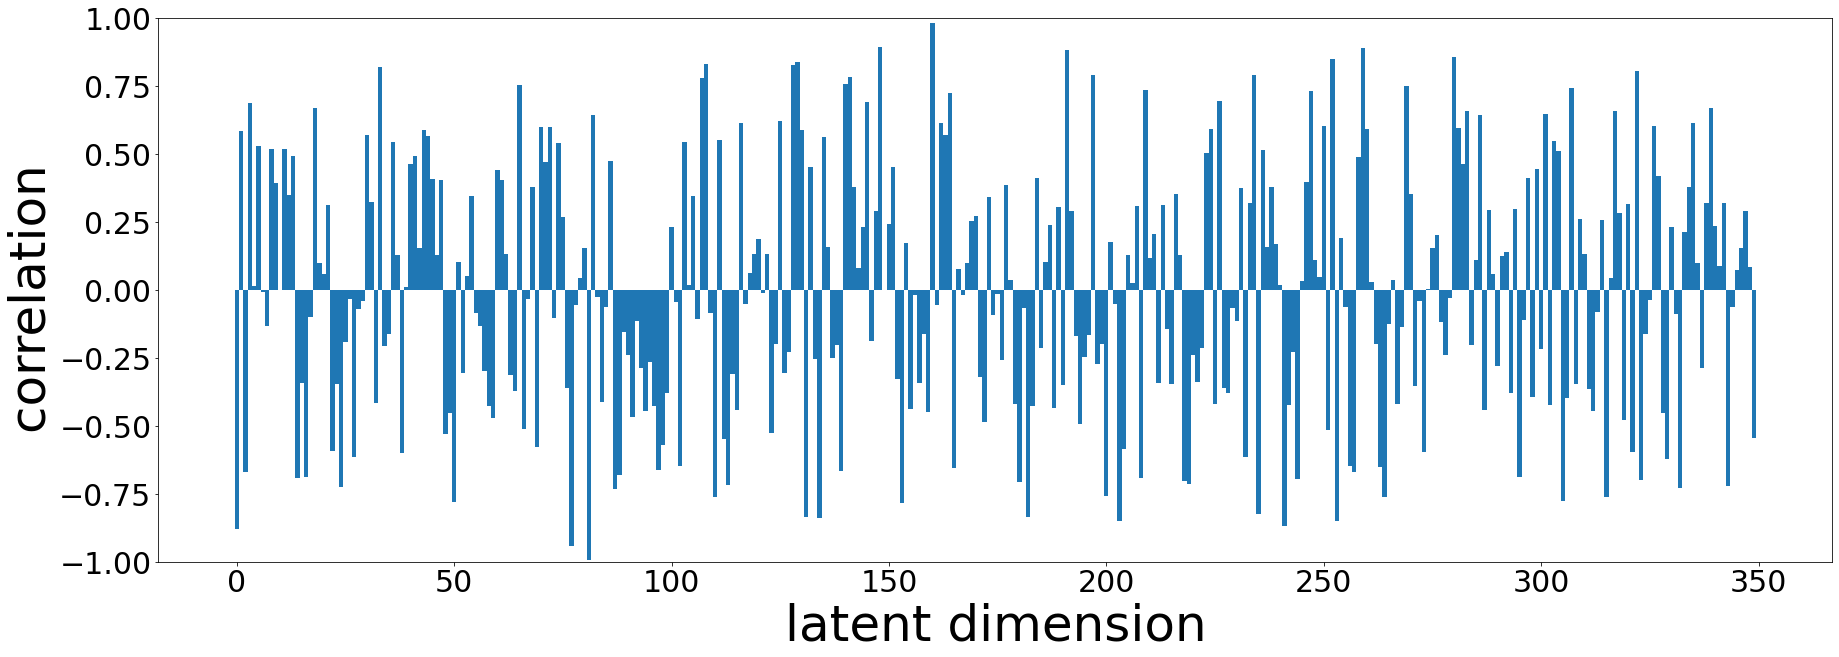

indices low to high [149  10 274   6  39 121   4 175 167 104 156 240 206  83 279 261  67 245
  26 178 266 325  29 272 101 316  79 249  53 202 117  78 161 289  20  85
 344 255 118 229 181  28 345 166 313 143  55 109 348 331 341 174  19  17
 336 168  51 186  73 106 285 248 296 230  92 277 210 291 265  46 205  37
 217  62   7 122  56 310 119 268 292 214 275  42  89 346  80 136 237 324
  35 158 196 193 239 154 201 146 120  25 254 199 124 262 284 276 138 211
  34 333 185 222 300 127 243 144 100 330 340 278 187 220  90 150 195 137
 169 133 176 314 309  95  75 170 198 290 318  93 337 347 192 147 288  57
 294 126  52 189 114 207  21  63 213 320 338 171 342 233  31 152 221 173
 212 157  15  54 105 308  23 215 190  12 216 271 270 227  76 311  64 231
  68 228 142 238 334 293  99 177   9 298 306 246  47  61  45  84 184 297
  32 327 225 179 267 242 302  58 183  96 188 155  60 115 287 299  94 312
 159 151  49 132 328  40 282  91  59  71  86 319 172 258  13 194  41 223
  66 304 236 251   8  11 123  4

In [27]:
# using all images find out which latent variables have high correlation to the classifier scores
df = pd.concat([pd.DataFrame(z_dist) , pd.DataFrame(images3D_clfscore)] , axis=1).reset_index()
df = df.drop( ['index'] , axis=1)

plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, cmap=plt.cm.Reds) # ,annot=True to see numbers
plt.xlabel("latent dimension ", fontsize=30)
plt.ylabel("latent dimension ", fontsize=30)
plt.show()

plt.figure(figsize=(30,10))
plt.bar(np.array(df.columns[:-1]), cor.iloc[-1].values[:-1] , width=1) # normalized
plt.xlabel("latent dimension", fontsize=50)
plt.ylabel("correlation ", fontsize=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim([-1,1])
plt.show()

print('indices low to high', np.argsort(np.abs(cor.iloc[-1].values[:-1])))
print('corscore low to high', np.round(np.sort(np.abs(cor.iloc[-1].values[:-1])),3))

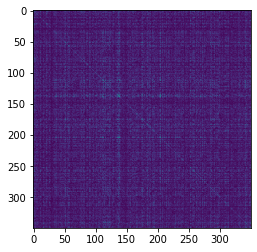

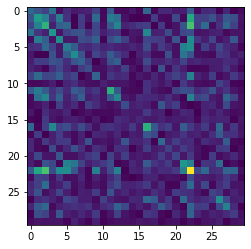

[[ 0.678 -0.515  0.396 -0.76  -0.077 -0.267  0.137  0.172 -0.192 -0.385
  -0.043]
 [-0.515  1.113 -0.894  0.31   0.846  0.287 -0.012  0.378 -0.124  0.691
  -0.055]
 [ 0.396 -0.894  1.304 -0.177 -0.604 -0.67  -0.011 -0.362  0.025 -0.425
  -0.086]
 [-0.76   0.31  -0.177  1.063 -0.108  0.409 -0.504 -0.518  0.282  0.43
   0.171]
 [-0.077  0.846 -0.604 -0.108  1.004  0.135 -0.134  0.477 -0.433  0.61
   0.023]
 [-0.267  0.287 -0.67   0.409  0.135  0.826 -0.598 -0.268  0.226  0.32
   0.21 ]
 [ 0.137 -0.012 -0.011 -0.504 -0.134 -0.598  0.985  0.537 -0.097 -0.421
  -0.27 ]
 [ 0.172  0.378 -0.362 -0.518  0.477 -0.268  0.537  0.639 -0.347  0.008
  -0.129]
 [-0.192 -0.124  0.025  0.282 -0.433  0.226 -0.097 -0.347  0.485 -0.095
  -0.085]
 [-0.385  0.691 -0.425  0.43   0.61   0.32  -0.421  0.008 -0.095  0.635
   0.075]
 [-0.043 -0.055 -0.086  0.171  0.023  0.21  -0.27  -0.129 -0.085  0.075
   0.188]]


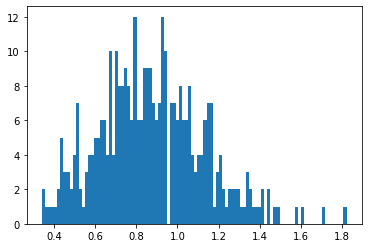

In [29]:
z_dist_ = z_dist - np.mean(z_dist, axis=0)
z_std = np.sqrt(np.var(z_dist_, axis=0))
cov = (z_dist_.T @ z_dist_) / (z_dist_.shape[0] )
plt.imshow(np.abs(cov))
plt.show()

plt.imshow(np.abs(cov[0:30, 0:30]))
plt.show()

_ = plt.hist(z_std, 100)

print(np.round(cov[0:11, 0:11], 3))
# print(np.corrcoef(z_dist[0], z_dist[10], rowvar=False))

In [30]:
def get_off_diag_values(x):
    x_flat = tf.reshape(x,[-1])[:-1]
    x_reshape = tf.reshape(x_flat,[x.shape[0]-1, x.shape[0]+1])[:, 1:]
    off_diag_values = tf.reshape(x_reshape,[-1])
    return off_diag_values

def compute_barlow_loss(z_a, z_b):
    z_a2b_loss = tf.reduce_mean(tf.abs(z_a - z_b))
    z_a_norm = (z_a - tf.reduce_mean(z_a, axis=0)) #/ tf.math.reduce_std(z_a, axis=0)
    z_b_norm = (z_b - tf.reduce_mean(z_b, axis=0)) #/ tf.math.reduce_std(z_b, axis=0)
    cov = tf.matmul(z_a_norm, z_b_norm, transpose_a=True) / tf.cast(tf.shape(z_a)[0], z_a.dtype)  # Cross-correlation matrix
    on_diag = tf.linalg.diag_part(cov) # vector of vars (z_std**2)  positives

    on_diag_loss = tf.reduce_mean( tf.nn.relu(1 - tf.sqrt(on_diag)) )
    off_diag = get_off_diag_values(cov)
    off_diag_loss    = tf.reduce_mean(tf.abs( off_diag**2 ))
    
    # on_diag_loss = tf.reduce_mean( tf.nn.relu(1 - on_diag) ) # tf.reduce_mean(tf.pow(on_diag -1, 2))
    # off_diag = tf.reshape( tf.reshape( tf.reshape(cov, [-1])[:-1] , (tf.shape(cov)[0]-1, tf.shape(cov)[0]+1) )[:, 1:]  , [-1])
    # off_diag_loss = tf.reduce_mean(tf.pow(off_diag, 2))
    return cov, on_diag, off_diag, on_diag_loss, off_diag_loss, z_a2b_loss 

cov, on_diag, off_diag, on_diag_loss, off_diag_loss, z_a2b_loss  = compute_barlow_loss(z_dist, z_dist)

In [31]:
# mean and var of most correlated dimensions

sorted_dim = np.argsort(np.abs(cor.iloc[-1].values[:-1]))[::-1]
for i in range(15):
    print('dim:' , sorted_dim[i], '   mean:' , z_dist[:, i].mean(), '   var:' , z_dist[:, i].var(), '   corr:' , cor.iloc[-1].values[sorted_dim[i]])


dim: 81    mean: 0.8394933    var: 0.6782379    corr: -0.9942266782235618
dim: 160    mean: 0.33720922    var: 1.1127206    corr: 0.983253449014491
dim: 77    mean: 0.36686397    var: 1.3036002    corr: -0.9427234504708393
dim: 148    mean: 0.16221322    var: 1.0629143    corr: 0.8924887918233623
dim: 259    mean: -0.68215495    var: 1.0035709    corr: 0.8921095075514278
dim: 191    mean: 0.003087014    var: 0.82578826    corr: 0.8819125050898011
dim: 0    mean: 0.026387155    var: 0.98462194    corr: -0.8802774891289006
dim: 241    mean: -0.71680164    var: 0.6392557    corr: -0.8668854472908424
dim: 280    mean: 0.25553247    var: 0.48549545    corr: 0.8562927870283958
dim: 252    mean: -0.39875007    var: 0.63529795    corr: 0.8510627694021099
dim: 253    mean: 0.5240187    var: 0.18842119    corr: -0.8497014285890783
dim: 203    mean: 0.72677594    var: 1.3001056    corr: -0.848355555668805
dim: 129    mean: -0.4732908    var: 0.93837    corr: 0.8373847559025633
dim: 134    mean: -

0


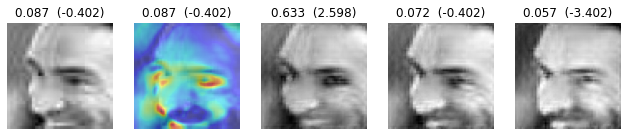

1


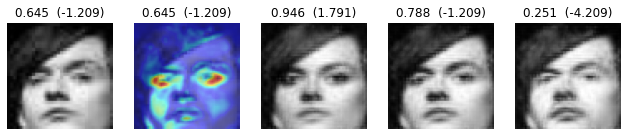

2


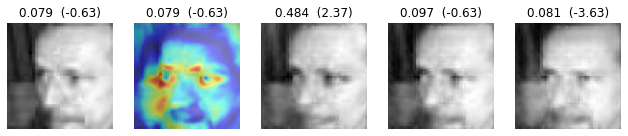

3


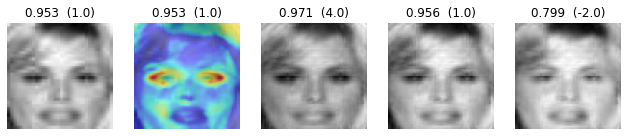

4


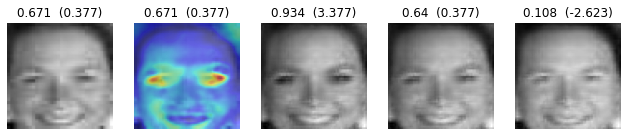

5


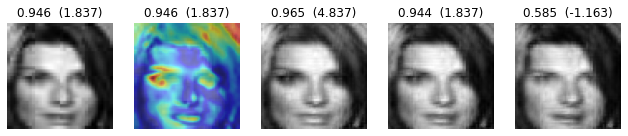

In [33]:

def interpretability(imgs, pert_dim, pert_value, ids):
    
    if sorted_dim[pert_dim] > 0 :
        plus_pert_value  =  pert_value
        minus_pert_value = -pert_value
    if sorted_dim[pert_dim] < 0 :
        plus_pert_value  = -pert_value
        minus_pert_value =  pert_value

    test_images_ = imgs # / 255 
    test_images_scores = clf_model( test_images_.repeat(3, -1) )
    test_z_images, test_z_scores  = encoder.predict(test_images_)
    test_recon_images = decoder.predict(test_z_images)
    test_recon_images_scores = clf_model(test_recon_images.repeat(3, -1))


    for idx in ids: # [7,11, 48,25, 9, 27, 39]: # range(200,300): 

        print(idx)

        latent_vec = test_z_images[idx]

        pert_latent_z_plus = np.copy(latent_vec)
        pert_latent_z_plus[pert_dim] = latent_vec[pert_dim] + plus_pert_value 
        pert_recon_img_plus = decoder.predict(np.expand_dims(pert_latent_z_plus, axis=0)) # decoder
        pert_plus_score = np.round(clf_model( pert_recon_img_plus.repeat(3, -1) ).numpy()[0][0],3)


        pert_latent_z_minus = np.copy(latent_vec) 
        pert_latent_z_minus[pert_dim] = latent_vec[pert_dim] + minus_pert_value 
        pert_recon_img_minus = decoder.predict(np.expand_dims(pert_latent_z_minus, axis=0))  # decoder
        pert_minus_score = np.round(clf_model( pert_recon_img_minus.repeat(3, -1) ).numpy()[0][0],3)


        diff_ssim = 1 - ssim(pert_recon_img_minus[0,:,:,0], pert_recon_img_plus[0,:,:,0], win_size=7,     K1=0.03 , K2=0.003,    sigma=0.5 , gradient=True, gaussian_weights = False , full=True)[2] # 1-grad, 2-ssim        
        # diff = pert_recon_img_minus[0,:,:,0] - pert_recon_img_plus[0,:,:,0]
        diff = np.abs(pert_recon_img_minus[0,:,:,0] - pert_recon_img_plus[0,:,:,0])
        diff = cv2.GaussianBlur(diff,(3,3),1) 

        fig, axs = plt.subplots(1, 5, figsize=(11,7))

        axs[0].imshow(test_images_[idx], cmap='gray')
        axs[0].set_title(str(np.round(test_images_scores[idx].numpy()[0],3)) + '  (' + str(np.round(test_z_images[idx][pert_dim],3)) + ')' )
        axs[0].axis('off')

        axs[1].imshow(test_images_[idx], cmap='gray', alpha=0.8)
        axs[1].imshow(diff, alpha=0.5, cmap='jet') #  , vmin=-0.4, vmax=0.4
        axs[1].set_title(str(np.round(test_images_scores[idx].numpy()[0],3)) + '  (' + str(np.round(test_z_images[idx][pert_dim],3)) + ')' )
        axs[1].axis('off')

        axs[2].imshow(pert_recon_img_plus[0], cmap='gray')
        axs[2].set_title(str(pert_plus_score) + '  (' + str(np.round(pert_latent_z_plus[pert_dim],3)) + ')' )
        axs[2].axis('off')

        axs[3].imshow(test_recon_images[idx], cmap='gray')
        axs[3].set_title(str(np.round(test_recon_images_scores[idx].numpy()[0],3)) + '  (' + str(np.round(test_z_images[idx][pert_dim],3)) + ')')
        axs[3].axis('off')

        axs[4].imshow(pert_recon_img_minus[0], cmap='gray')
        axs[4].set_title(str(pert_minus_score) + '  (' + str(np.round(pert_latent_z_minus[pert_dim],3)) + ')')
        axs[4].axis('off')

        plt.show()

pert_dim = 3 
pert_value = 3
ids =  range(0,6) # [7,11, 48,25, 9, 27, 39, 52, 83, 88, 92, 94, 118, 136, 148, 174] # range(200,300)
interpretability(images, pert_dim, pert_value, ids)